# Investigate Failures and Potential Bias of BCNN

BCNN was used for the paper https://arxiv.org/abs/1905.07424. This notebook was made by Mike Walmsley ([@mike_walmsley_](https://twitter.com/mike_walmsley_)) in response to reviewer comments.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!git pull

Already up to date.


In [3]:
import os
from collections import Counter

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from PIL import Image
from scipy.stats import binom
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree
from interpret import show

from shared_astro_utils import astropy_utils, matching_utils

/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Load Data

**Dear reader - please feel free to skip this section**

In [4]:
# QUESTION = 'bars'
QUESTION= 'smooth'

In [5]:
df = pd.read_parquet('/data/repos/zoobot/notebooks/{}_test_predictions_and_gz2_catalog.parquet'.format(QUESTION))

In [6]:
# gz2 catalog doesn't have nsa, let's merge that in for astro features
nsa_catalog_loc = '../data/nsa_v1_0_1.fits'
if not os.path.isfile(nsa_catalog_loc):
    !dvc pull -r s3 {nsa_catalog_loc}.dvc

In [7]:
physical_cols = ['MAG', 'Z', 'SERSIC_MASS', 'PETRO_BA50', 'PETRO_BA90', 'PETRO_THETA', ]

In [8]:
cols_to_load = ['RA', 'DEC'] + physical_cols
nsa_catalog = Table.read(nsa_catalog_loc)[cols_to_load]
for col in cols_to_load:
    nsa_catalog[col.lower()] = nsa_catalog[col]
    del nsa_catalog[col]
nsa_catalog = nsa_catalog.to_pandas()

In [9]:
nsa_df, _ = matching_utils.match_galaxies_to_catalog_pandas(df, nsa_catalog, matching_radius=u.arcsec * 1000)

In [10]:
del nsa_catalog  # to conserve memory

### Add Loss Metrics

In [11]:
if question == 'bar':
    k_col = 't03_bar_a06_bar_count'
    n_col = 'bar_total-votes'
    fraction_col = 't03_bar_a06_bar_fraction'

def ml_likelihood(row):
    return binom.pmf(k=row[k_col], n=row[n_col], p=row['rho_prediction'])

In [12]:
def add_loss_metrics(df):
    df['bcnn_likelihood'] = df.apply(ml_likelihood, axis=1)
    df['absolute_error'] = np.abs(df['rho_prediction'] - df[fraction_col])
    return df

In [13]:
nsa_df = add_loss_metrics(nsa_df)

In [14]:
nsa_df = nsa_df.sort_values('bcnn_likelihood', ascending=True)

In [15]:
assert Counter(nsa_df.columns.values).most_common(1)[0][1] == 1  # check there are no duplicated columns

# Where does the CNN Go Wrong? (Start here, Reader)

## Visualise Failures

What kind of galaxies does our CNN do poorly on? Let's look at some examples.

In [16]:
def visualise_error(galaxy, ax=None, save_loc=None):
    img = Image.open(galaxy['png_loc'])
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(img)
    fontdict = {'size': 14, 'color': 'white'}
    ax.text(0.1, .25, r'$\hat{\rho}$: ' + '{:.2f}'.format(galaxy['rho_prediction']), transform=ax.transAxes, fontdict=fontdict)
    ax.text(0.1, .85, r'$N$: '+ '{}'.format(galaxy['total_votes']), transform=ax.transAxes, fontdict=fontdict)
    ax.text(0.1, .1, r'$\frac{k}{N}$: '+ '{:.2f}'.format(galaxy[fraction_col]), transform=ax.transAxes, fontdict=fontdict)
    ax.axis('off')
    ax.grid(False)
    if save_loc:
        fig.savefig(save_loc)
#     plt.savefig(os.path.join(save_dir, 'high_prob_error_0.png'))
#     plt.savefig(os.path.join(save_dir, 'high_prob_error_0.eps'))

### Worst Failures

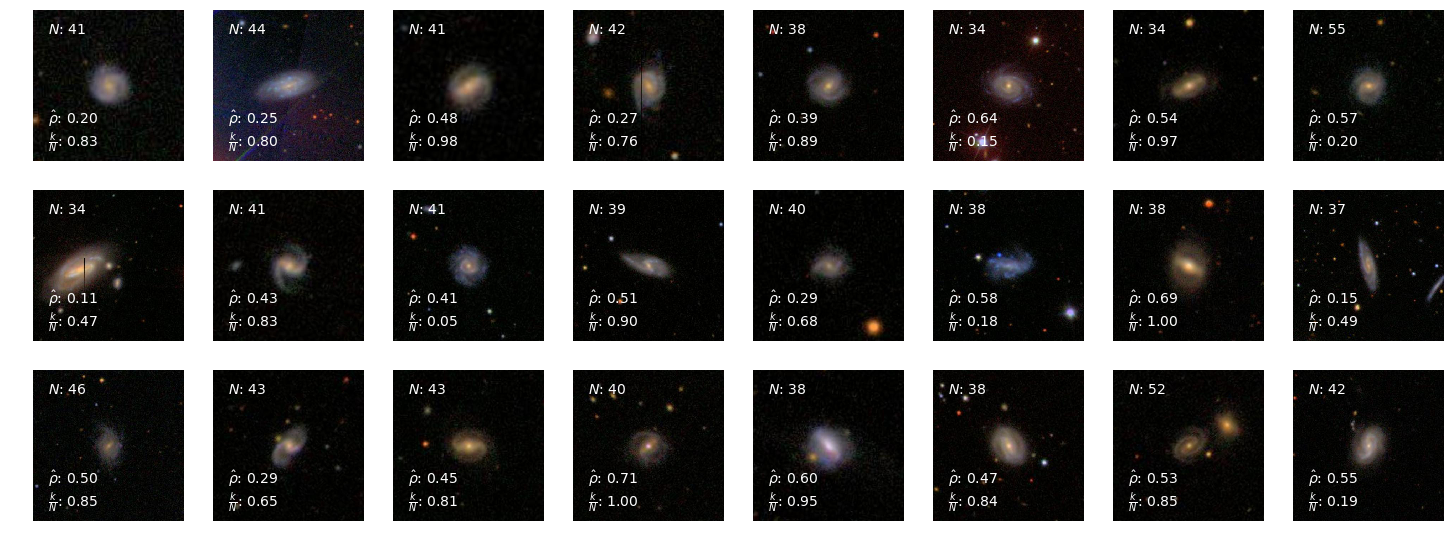

In [17]:
n_cols = 8
n_rows = 3
scale = 2.5
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(scale * n_cols, scale * n_rows))
for n, ax in enumerate(axes.flatten()):
    visualise_error(nsa_df.query('total_votes > 30').iloc[n], ax)
fig.tight_layout(pad=0., h_pad=0., w_pad=0.)

### Best Successes

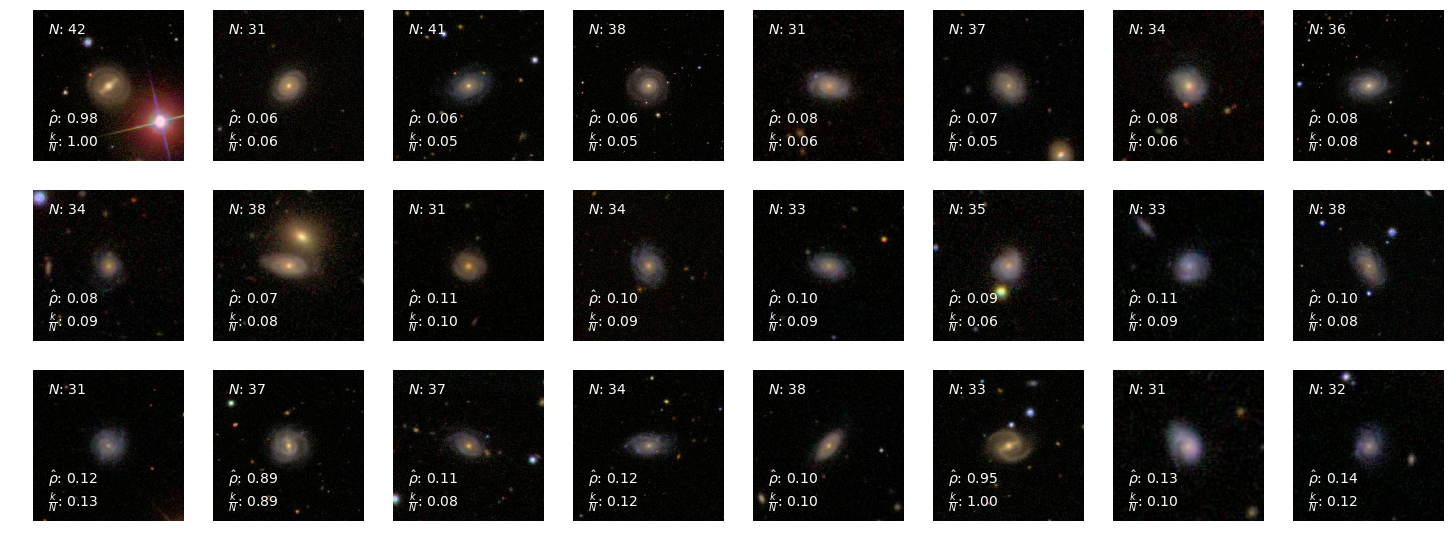

In [18]:
n_cols = 8
n_rows = 3
scale = 2.5
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(scale * n_cols, scale * n_rows))
for n, ax in enumerate(axes.flatten()):
    visualise_error(nsa_df.sort_values('bcnn_likelihood', ascending=False).query('total_votes > 30').iloc[n], ax)  # successful galaxies
fig.tight_layout(pad=0., h_pad=0., w_pad=0.)

Looks like the network is somewhat better at identifying galaxies without bars than galaxies with bars. The failures are a bit more barred than the successes, by eye. Let's quantify this below.

# Visualise Performance (Loss) w.r.t. Catalog Features

In [19]:
def median_likelihood_by_col(input_df, col, bins=10, output_col='bcnn_likelihood'):
    binned_col = col + '_binned'
    df = input_df.copy()
    df[binned_col] = pd.cut(df[col], bins=bins).apply(lambda x: x.right - (x.right - x.left)/2.).astype(float)
    return df.reset_index()

In [20]:
nsa_df['log_sersic_mass'] = np.log10(nsa_df['sersic_mass'])

In [21]:
relevant_gz_cols =  ['t03_bar_a06_bar_fraction', 't01_smooth_or_features_a02_features_or_disk_fraction', 't04_spiral_a08_spiral_fraction']

In [22]:
relevant_physical_cols = ['mag', 'z', 'log_sersic_mass', 'petro_ba50', 'petro_ba90', 'petro_theta']

In [23]:
def visualise_performance(input_df, col, limits=None):
    df = input_df.copy()
    if limits:
        df = df.query('{} > {}'.format(col, limits[0])).query('{} < {}'.format(col, limits[1]))
    fig, ax = plt.subplots()
    ax.set_title('{} vs. performance'.format(col))
    ax.scatter(x=df[col], y=df['bcnn_likelihood'], alpha=0.2, label='Galaxy')
    sns.jointplot(data=df, y='bcnn_likelihood', x=col, kind='kde')
    tmp_df = median_likelihood_by_col(df, col=col, bins=8)
    binned_col = col + '_binned'
    grp_df = tmp_df.groupby(binned_col).agg({'bcnn_likelihood': 'median'}).reset_index()
    ax.plot(grp_df[binned_col], grp_df['bcnn_likelihood'], 'r--', marker='o', label='Median')
    ax.set_xlabel(r'Vote fraction $\frac{k}{n}$')
    ax.set_ylabel('BCNN Likelihood')
    ax.legend()

### Galaxy Zoo 2 Votes vs. Performance

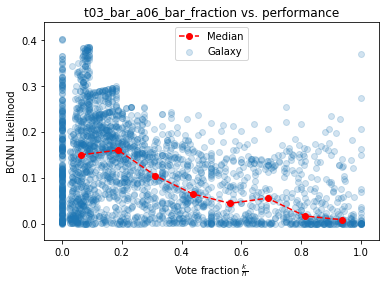

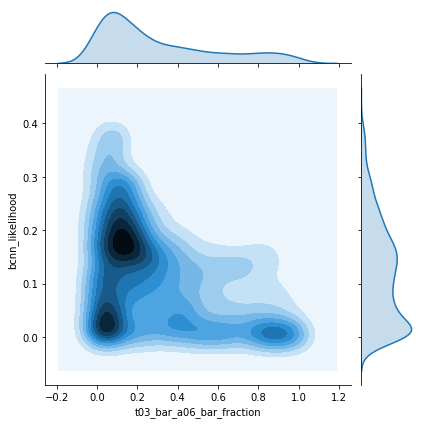

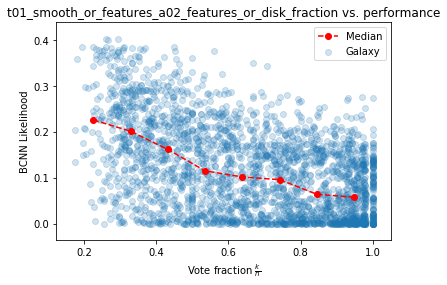

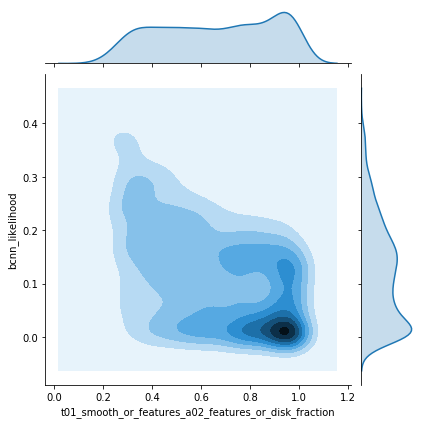

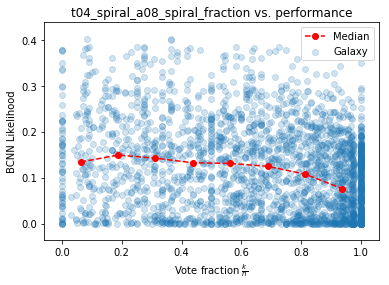

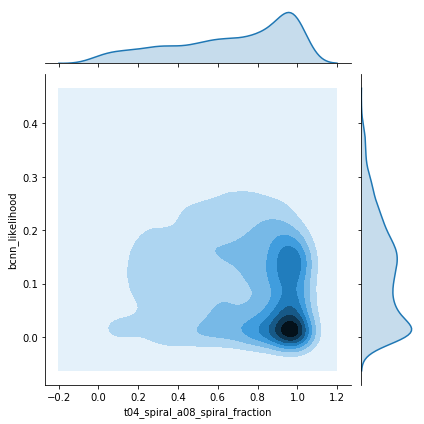

In [24]:
for col in relevant_gz_cols:
    visualise_performance(nsa_df, col)

Conclusions
1. The network is indeed somewhat better at identifying non-bars than identifying bars. Makes sense: bars are rare. Active learning should help improve this by selecting more bars.
2. Featured galaxies are harder to label. This is probably an effect of overconfidence: featured galaxies recieve more 'bar or not bar?' votes (i.e. N is larger), making the true uncertainties much narrower. In consequence, our slightly overconfident network is much more surprised than it expects.

## Physical Params (from NSA) vs. Performance

In [25]:
limits = {
    'mag': [14., 18.],
    'z': None,
    'log_sersic_mass': [8.5, 11.2],
    'petro_ba50': [0.4, 1.],
    'petro_ba90': [0.4, 1.],
    'petro_theta': [2.5, 20.]
}

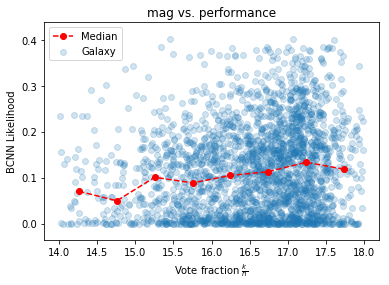

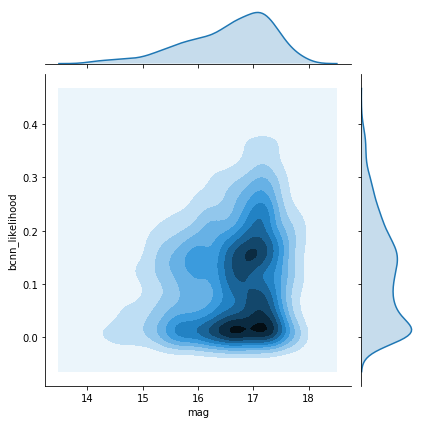

In [26]:
visualise_performance(nsa_df, 'mag', limits=limits['mag'])

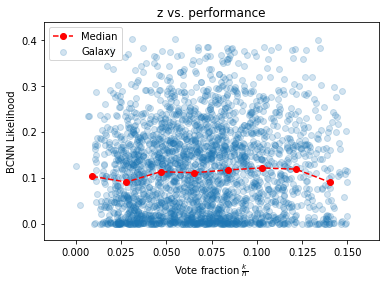

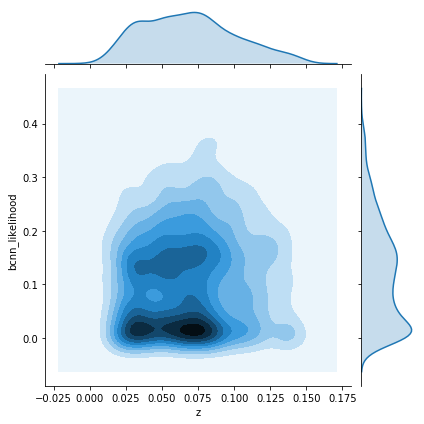

In [27]:
visualise_performance(nsa_df, 'z', limits=limits['z'])

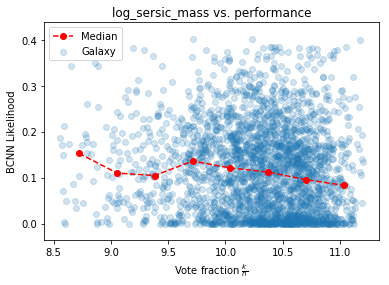

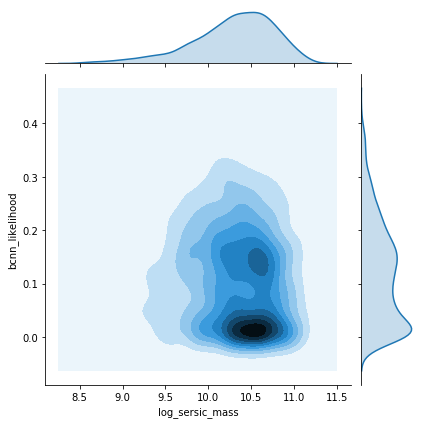

In [28]:
visualise_performance(nsa_df, 'log_sersic_mass', limits=limits['log_sersic_mass'])

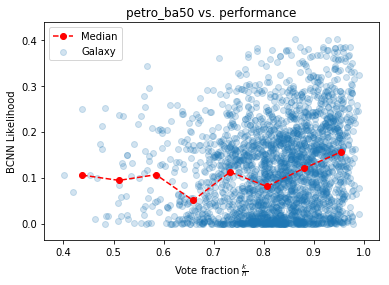

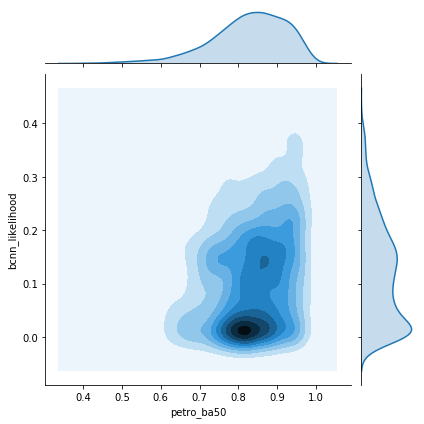

In [29]:
visualise_performance(nsa_df, 'petro_ba50', limits=[0.4, 1.])

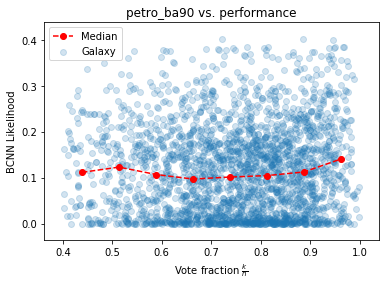

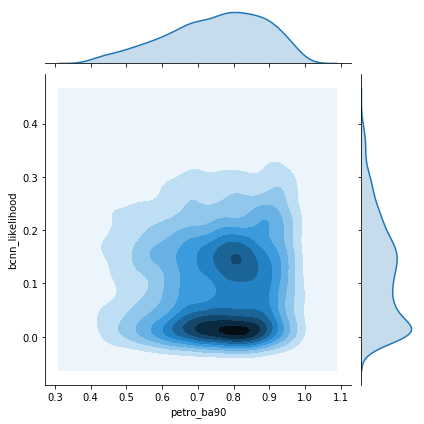

In [30]:
visualise_performance(nsa_df, 'petro_ba90', limits=limits['petro_ba90'])

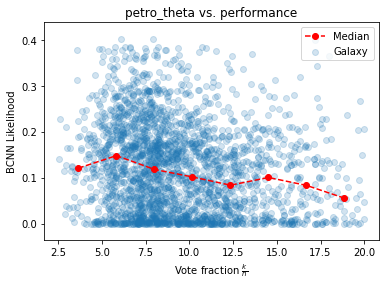

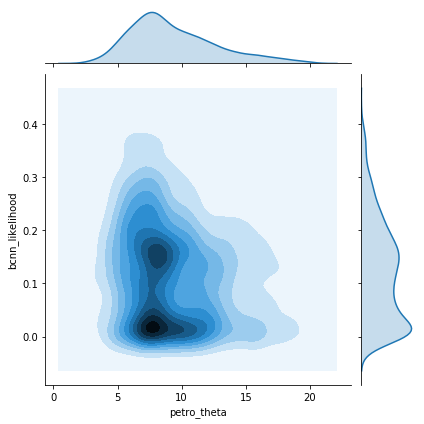

In [31]:
visualise_performance(nsa_df, 'petro_theta', limits=limits['petro_theta'])

There's a lot going on here, and it looks like most effects are weak vs. the natural scatter in the data. 

Let's try something more quantitative...

## Use Regression Model to Disentagle

We're trying to work out what features (galaxy properties) predict some value (bcnn likelihood i.e. cnn performance). This is a regression problem. Let's fit an explainable regression model and see what it thinks the effect of each feature is.

In [32]:
safe_df = nsa_df.copy()
for col, lims in limits.items():
    if lims:
        print(col, lims)
        safe_df = safe_df.query('{} > {}'.format(col, lims[0])).query('{} < {}'.format(col, lims[1]))
        print(len(safe_df))
safe_df = safe_df.dropna()

mag [14.0, 18.0]
2389
log_sersic_mass [8.5, 11.2]
2362
petro_ba50 [0.4, 1.0]
2358
petro_ba90 [0.4, 1.0]
2323
petro_theta [2.5, 20.0]
2230


In [33]:
seed = 1
ebm = ExplainableBoostingRegressor(random_state=seed)
feature_cols = relevant_physical_cols + relevant_gz_cols
y = safe_df['bcnn_likelihood'].values
X = safe_df[[col.lower() for col in feature_cols]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

In [34]:
ebm = ExplainableBoostingRegressor(random_state=seed)
ebm.fit(X_train, y_train)

ExplainableBoostingRegressor(data_n_episodes=2000, early_stopping_run_length=50,
                             early_stopping_tolerance=1e-05,
                             feature_names=['mag', 'z', 'log_sersic_mass',
                                            'petro_ba50', 'petro_ba90',
                                            'petro_theta',
                                            't03_bar_a06_bar_fraction',
                                            't01_smooth_or_features_a02_features_or_disk_fraction',
                                            't04_spiral_a08_spiral_fraction'],
                             feature_step_n_inner_bags=0,
                             feature_types=['continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous

In [35]:
from sklearn.metrics import mean_squared_error

In [36]:
predictions = ebm.predict(X_test)
print('mse' , mean_squared_error(y_test, predictions))
print('abs', np.abs(predictions-y_test).mean())

mse 0.0061793509403920855
abs 0.06465146578024407


Okay, seems to be quite good at predicting CNN performance (this is quite interesting in itself, for potential performance optimisations, but that's for another paper...). So how do the catalog features affect the CNN performance?

In [37]:
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

<!-- http://127.0.0.1:7170/5198945472/ -->

(You won't be able to see this without running the notebook live, so I'm using screenshots)

The summary tab shows that, as we saw earlier, the most important features are the GZ2 votes for bars and featured/smooth, and that these have by far the most significant effects in performance.

<img src=ebm_summary.png>

Inspecting these features (with the dropdown) shows that, all else being equal, the CNN is better at non-barred and smoother galaxies, matching what we saw above.

<img src=ebm_bar.png>
<img src=ebm_features_or_disk.png>

The CNN appears relatively unbiased with respect to non-morphological astrophysical features. The most significant remaining effect is inclination (`petro_ba50`, `petro_ba90`). The dropdown shows that, all else being equal, the CNN finds face-on galaxies (b/a > 0.85 or so) slightly easier than inclined galaxies when predicting bars. This is a much smaller effect than the morphological effects above.

<img src=ebm_petro_ba90.png>

Finally, let's extract the key plot (the feature weightings) for the paper.

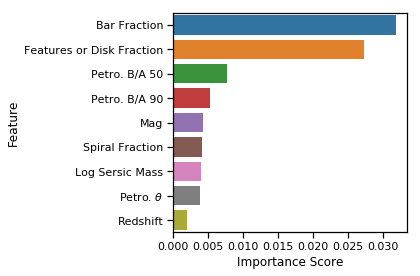

In [38]:
results = ebm_global.data()
importance_pairs = dict(zip(results['names'], results['scores']))

renamer = {
    't03_bar_a06_bar_fraction': 'Bar Fraction',
    't01_smooth_or_features_a02_features_or_disk_fraction': 'Features or Disk Fraction',
    'petro_ba50': 'Petro. B/A 50',
    'petro_ba90': 'Petro. B/A 90',
    'mag': 'Mag',
    't04_spiral_a08_spiral_fraction': 'Spiral Fraction',
    'log_sersic_mass': 'Log Sersic Mass',
    'petro_theta': r'Petro. $\theta$',
    'z': 'Redshift'
}
data = pd.DataFrame(data=[{'Feature': renamer[feature], 'Importance Score': score} for feature, score in importance_pairs.items()])

sns.set_context('notebook')  # I prefer this to 'paper', even for papers
fig, ax = plt.subplots()
sns.barplot(data=data.sort_values('Importance Score', ascending=False), x='Importance Score', y='Feature', ax=ax)
fig.tight_layout()
fig.savefig('ebm_importance_barplot.pdf')
fig.savefig('ebm_importance_barplot.png')